# Importing Required Librarires

In [2]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading Data

In [5]:
!hadoop fs -copyToLocal s3://whales-classification/data.np data/

18/04/27 00:22:12 INFO s3n.S3NativeFileSystem: Opening 's3://whales-classification/data.np' for reading


The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](.emr_processing/DataProcessing.ipynb). The preprocessed is a numpy array with `4144531` rows with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [3]:
data  = np.load("data/data.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

# Train - Test - Validation

The data is shuffled and divided as follow:
* Training: 70%
* Validation: 15%
* Testing: 15%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3
* Step size shrinkage used in update to prevents overfitting = 0.3
* Evaluation Criterion: `Maximize Loglikelihood`
* Maximum Number of Iterations = 1000
* Early Stop if score on Validation does not improve for 5 iterations

In [ ]:
param = {'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 7
param['eval_metric'] = 'logloss'
plst = param.items()
num_round = 100
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5, verbose_eval=True)

In [ ]:
num_round = 1000
bst1000 = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5, verbose_eval=True)

## Visualize the Feature Importance

In [ ]:
def visualize_features(bst, features_map = None):
    xgb.plot_importance(bst)
    plt.show()
    if features_map:
        print("Feature Mapping:")
        for x in features_map:
            print(x, "\t: ", features_map[x])

100 Iterations


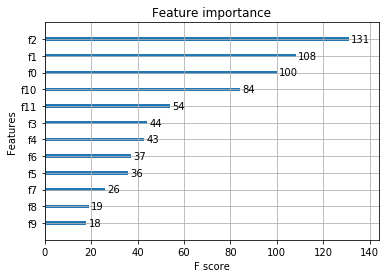

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak



1000 Iterations


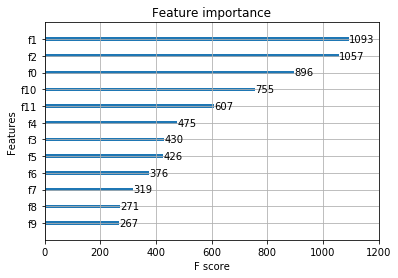

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [ ]:
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

print("100 Iterations")
visualize_features(bst, features_map)

print("\n\n\n1000 Iterations")
visualize_features(bst1000, features_map)

Clearly, Eigen Projection 2, Eigen Projection 3, Eigen Projection 1, RMSE and Peak2Peak are the most important features.

# Margin Plots on Test Data

In [ ]:
y_pred_100 = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [ ]:
import matplotlib.pyplot as plt
def get_margin_plot(y_pred, y_test, thresholds, legends = None, title=None, style=['b', 'r']):
    accuracy_1 = []
    accuracy_0 = []
    for thresh in thresholds:
        y_test_i = y_test[y_test == 1]
        y_pred_i = y_pred[y_test == 1]
        correct = np.sum(y_pred_i > thresh)
        accuracy_1.append(1.0 * correct / len(y_test_i))

        y_test_i = y_test[y_test == 0]
        y_pred_i = y_pred[y_test == 0]
        correct = np.sum(y_pred_i <= thresh)
        accuracy_0.append(1.0 * correct / len(y_test_i))
    
    plt.plot(thresholds, accuracy_1, style[0])
    plt.plot(thresholds, accuracy_0, style[1])
    if legends:
        plt.legend(legends)
    plt.xlabel('Margin Score')
    plt.ylabel('Accuracy')
    if title:
        plt.title(title)

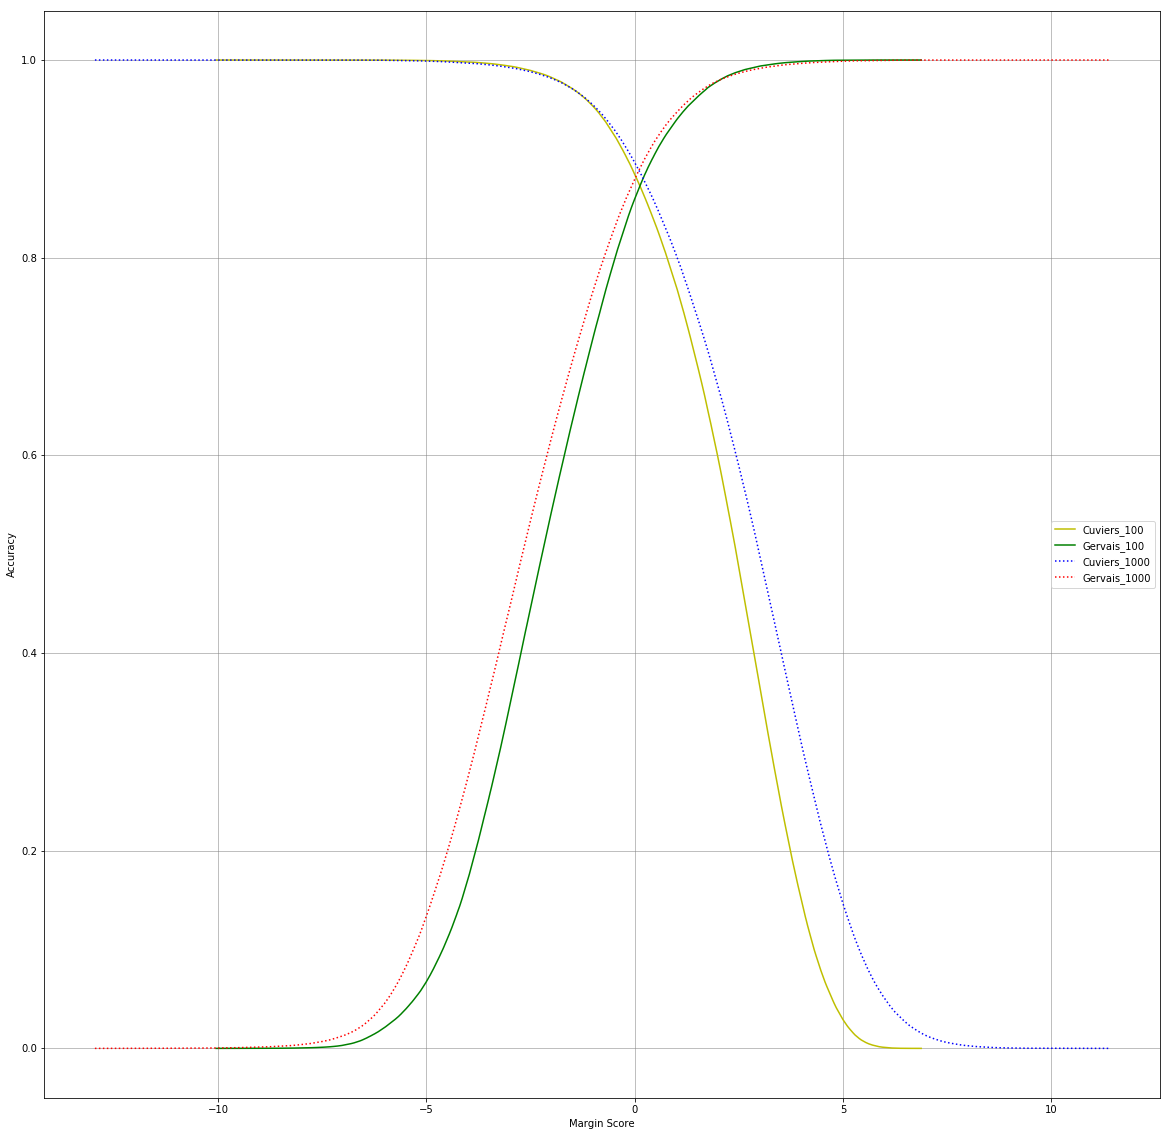

In [ ]:
plt.figure(figsize=(20, 20))
legends = ['Cuviers_100', 'Gervais_100']
thresholds = sorted(np.unique(np.round(y_pred_100, 2)))
get_margin_plot(y_pred_100, y_test, thresholds, legends = legends, style=['y', 'g'])

legends = legends + ['Cuviers_1000', 'Gervais_1000']
thresholds = sorted(np.unique(np.round(y_pred_1000, 2)))
get_margin_plot(y_pred_1000, y_test, thresholds, legends = legends, style=['b:', 'r:'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

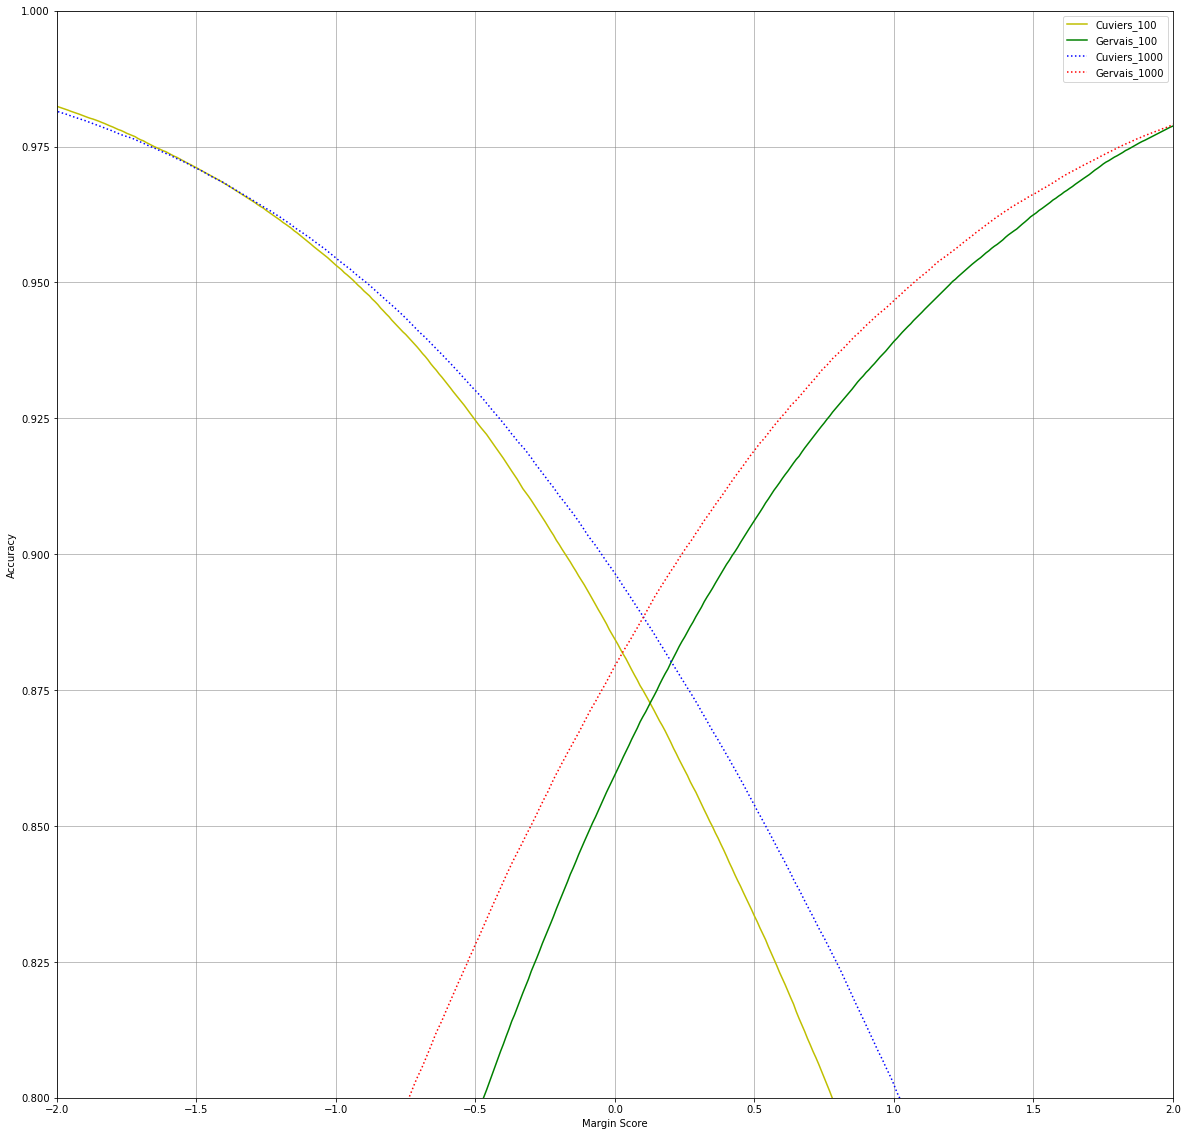

In [ ]:
plt.figure(figsize=(20, 20))
legends = ['Cuviers_100', 'Gervais_100']
thresholds = sorted(np.unique(np.round(y_pred_100, 2)))
get_margin_plot(y_pred_100, y_test, thresholds, legends = legends, style=['y', 'g'])

legends = legends + ['Cuviers_1000', 'Gervais_1000']
thresholds = sorted(np.unique(np.round(y_pred_1000, 2)))
get_margin_plot(y_pred_1000, y_test, thresholds, legends = legends, style=['b:', 'r:'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.xlim([-2, 2])
plt.ylim([0.8, 1])
plt.show()

## ROC Curve

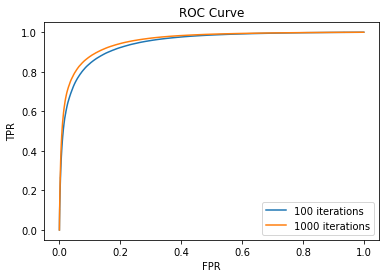

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_100)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.legend(['100 iterations','1000 iterations'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.show()

In [ ]:
import pickle

pickle.dump({
    'y_test': y_test,
    'y_pred_100': y_pred_100,
    'y_pred_1000': y_pred_1000
}, open('output.pk', 'wb'))

!hadoop fs -copyFromLocal output.pk s3://whales-classification/

18/04/27 03:28:28 INFO s3n.MultipartUploadOutputStream: close closed:false s3://whales-classification/output.pk
18/04/27 03:28:29 INFO s3n.MultipartUploadOutputStream: close closed:true s3://whales-classification/output.pk
